In [13]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
from nn_base_models import FeedforwardNN

Epoch 0: Loss = 3.715407e+03
Epoch 500: Loss = 5.931388e+01
Epoch 1000: Loss = 9.043266e+00
Epoch 1500: Loss = 3.900762e+00
Epoch 2000: Loss = 2.334221e+00
Epoch 2500: Loss = 1.420584e+00


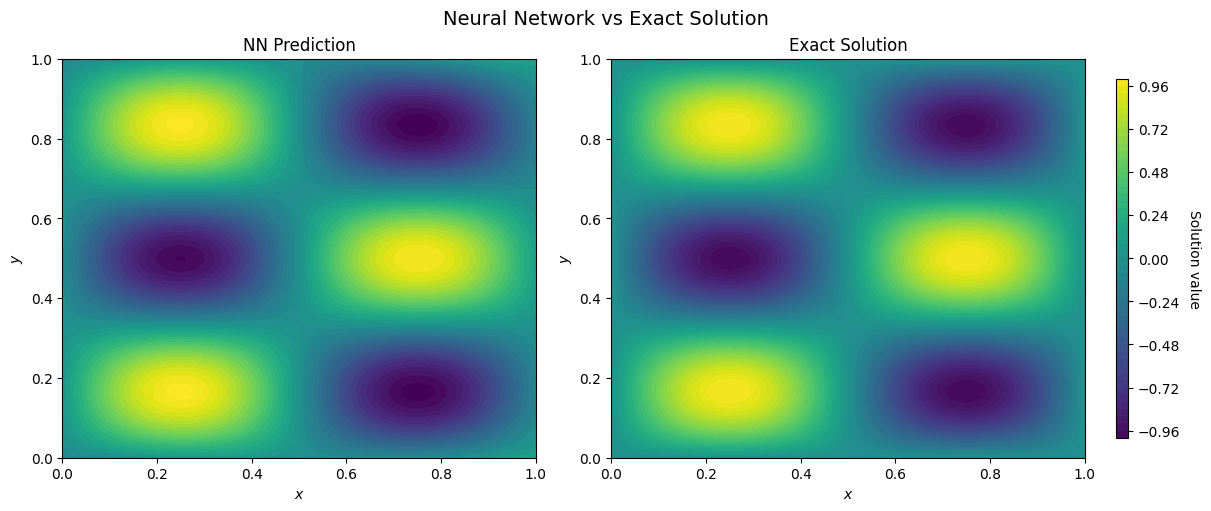

In [50]:
# Forcing function: f(x, y) = 13pi^2 sin(2pix) sin(3piy)
def f_rhs(x, y):
    return 13 * np.pi**2 * torch.sin(2 * np.pi * x) * torch.sin(3 * np.pi * y)

# # Function to sample points in the interior and on the boundary
# def sample_points(n_interior=1000, n_boundary=200, seed=42):
#     torch.manual_seed(seed)  # Set the seed for reproducibility

#     # Interior: random points in (0,1) × (0,1)
#     x_interior = torch.rand((n_interior, 2), dtype=torch.float32)

#     # Ensure n_boundary is divisible by 4
#     if n_boundary % 4 != 0:
#         raise ValueError("n_boundary must be divisible by 4 for even distribution along all edges.")

#     edge = torch.linspace(0, 1, n_boundary // 4)

#     # Drop the last point from each edge except one to avoid corner duplication
#     xb = torch.cat([
#         torch.stack([edge, torch.zeros_like(edge)], dim=1),                  # bottom edge
#         torch.stack([torch.ones_like(edge), edge], dim=1),                   # right edge
#         torch.stack([edge.flip(0), torch.ones_like(edge)], dim=1),           # top edge
#         torch.stack([torch.zeros_like(edge), edge.flip(0)], dim=1)           # left edge
#     ], dim=0)
# 
    # return x_interior, xb

def sample_points(n_interior: int, n_boundary: int):
    # Interior points in uniform grid
    n_side = int(np.sqrt(n_interior))
    xi = np.linspace(0, 1, n_side)
    X, Y = np.meshgrid(xi, xi)
    x_interior = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)

    # Boundary points, equally spaced along each edge
    n_edge = n_boundary // 4
    edge = np.linspace(0, 1, n_edge)
    xb = torch.tensor(np.concatenate([
        np.stack([edge, np.zeros_like(edge)], axis=1),
        np.stack([edge, np.ones_like(edge)], axis=1),
        np.stack([np.zeros_like(edge), edge], axis=1),
        np.stack([np.ones_like(edge), edge], axis=1)
    ]), dtype=torch.float32)

    return x_interior, xb


# Loss function
def poisson_loss(model, x_interior, x_boundary, gamma=100.0):
    x_interior.requires_grad_(True)
    u = model(x_interior)

    # Compute Laplacian using autograd
    grad_u = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dx, du_dy = grad_u[:, 0:1], grad_u[:, 1:2]
    d2u_dx2 = torch.autograd.grad(du_dx, x_interior, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 0:1]
    d2u_dy2 = torch.autograd.grad(du_dy, x_interior, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0][:, 1:2]
    lap_u = d2u_dx2 + d2u_dy2

    # PDE residual
    f_vals = f_rhs(x_interior[:, 0:1], x_interior[:, 1:2])
    loss_pde = torch.mean((lap_u + f_vals)**2)

    # Boundary loss
    u_boundary = model(x_boundary)
    loss_bc = torch.mean(u_boundary**2)

    return loss_pde + gamma * loss_bc

# Model training function
def train_poisson(model, epochs=3000, lr=1e-3, gamma=100.0, verbose=True, x_int=400, x_bd=100):
    x_int, x_bd = sample_points(x_int,x_bd)
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimiser.zero_grad()
        loss = poisson_loss(model, x_int, x_bd, gamma)
        loss.backward()
        optimiser.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6e}")


# Sensecheck the model has worked
model = FeedforwardNN(input_dim=2, output_dim=1, hidden_layers=3, hidden_units=30, activation='swish')
train_poisson(model, epochs=3000, lr=1e-3, gamma=100.0)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

with torch.no_grad():
    u_pred = model(xy).view(100, 100).numpy()

u_true = np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)

# Ensure they're ont the same scale
# Compute global color limits
vmin = min(u_pred.min(), u_true.min())
vmax = max(u_pred.max(), u_true.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot NN prediction
cf1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title("NN Prediction")
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

# Plot exact solution
cf2 = axes[1].contourf(X, Y, u_true, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title("Exact Solution")
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$y$")

# Add single shared colorbar
cbar = fig.colorbar(cf2, ax=axes, orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
cbar.set_label("Solution value", rotation=270, labelpad=15)

plt.suptitle("Neural Network vs Exact Solution", fontsize=14)
plt.show()


In [ ]:
# generate results for nn's of different depth and width and with the ReLu vs Tanh activation functions

activations = ['tanh', 'swish']
layer_counts = list(range(1, 11)) 
widths = list(range(1, 21))   

results = []

for act in activations:
    for layers in layer_counts:
        for width in widths:
            print(f"Training: activation={act}, layers={layers}, width={width}")
            model = FeedforwardNN(input_dim=2, output_dim=1,
                                  hidden_layers=layers,
                                  hidden_units=width,
                                  activation=act)
            start_time = time.time()
            train_poisson(model, epochs=1500, lr=1e-3, gamma=100.0, verbose=False)
            duration = time.time() - start_time

            # Evaluate on uniform 2D grid
            x = np.linspace(0, 1, 100)
            y = np.linspace(0, 1, 100)
            X, Y = np.meshgrid(x, y)
            xy_test = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

            with torch.no_grad():
                u_pred = model(xy_test).view(100, 100).numpy()
            u_true = np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)
            mse = np.mean((u_pred - u_true) ** 2)

            results.append({
                "activation": act,
                "layers": layers,
                "width": width,
                "mse": mse,
                "train_time_sec": duration
            })

# Save to CSV
results_df = pd.DataFrame(results)

Training: activation=tanh, layers=1, width=1
Training: activation=tanh, layers=1, width=2
Training: activation=tanh, layers=1, width=3
Training: activation=tanh, layers=1, width=4
Training: activation=tanh, layers=1, width=5
Training: activation=tanh, layers=1, width=6
Training: activation=tanh, layers=1, width=7
Training: activation=tanh, layers=1, width=8
Training: activation=tanh, layers=1, width=9
Training: activation=tanh, layers=1, width=10
Training: activation=tanh, layers=1, width=11
Training: activation=tanh, layers=1, width=12
Training: activation=tanh, layers=1, width=13
Training: activation=tanh, layers=1, width=14
Training: activation=tanh, layers=1, width=15
Training: activation=tanh, layers=1, width=16
Training: activation=tanh, layers=1, width=17
Training: activation=tanh, layers=1, width=18
Training: activation=tanh, layers=1, width=19
Training: activation=tanh, layers=1, width=20
Training: activation=tanh, layers=1, width=21
Training: activation=tanh, layers=2, width=

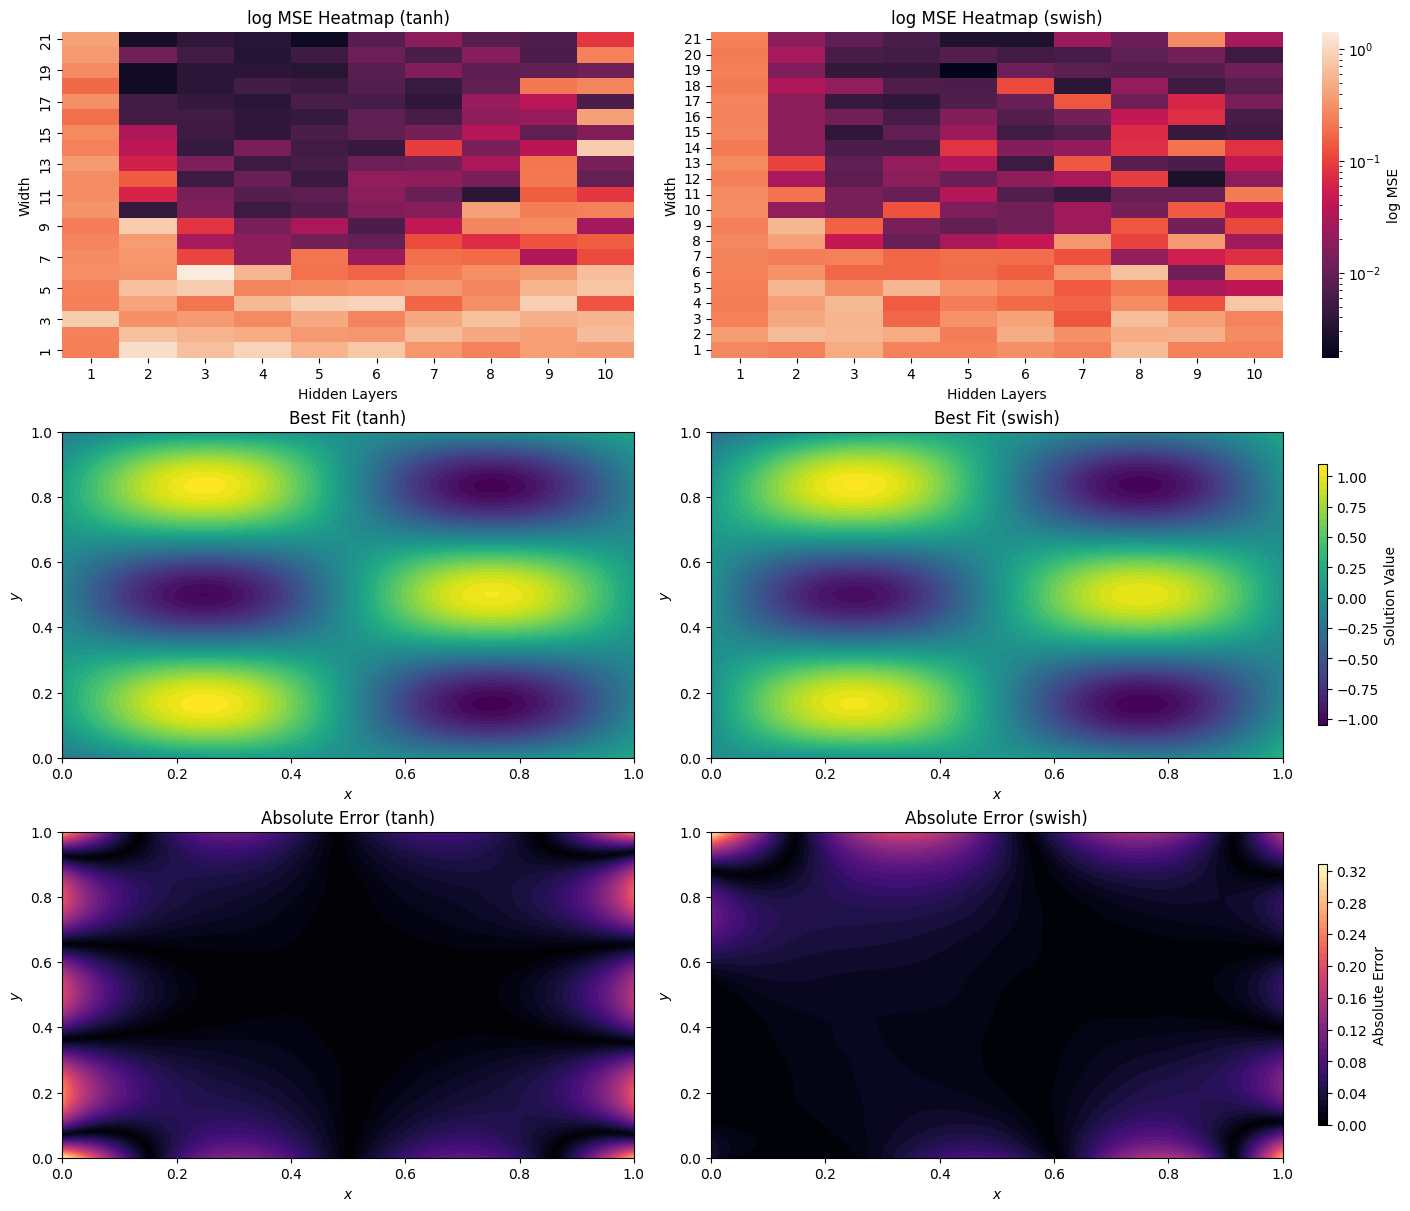

In [22]:
results_df = pd.read_csv("Data/PDE_data/poisson_2D_results.csv")

def true_solution(X, Y):
    return np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)

# get best configurations
best_configs = {
    act: results_df[results_df["activation"] == act].loc[results_df[results_df["activation"] == act]["mse"].idxmin()]
    for act in results_df["activation"].unique()
}

# make eval grid
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)
u_true = true_solution(X, Y)

# Colour scales
log_norm = mcolors.LogNorm(vmin=results_df["mse"].min(), vmax=results_df["mse"].max())

# Plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12), constrained_layout=True)

for j, act in enumerate(["tanh", "swish"]):
    # Heatmap
    df_act = results_df[results_df["activation"] == act]
    heatmap_data = df_act.pivot(index="width", columns="layers", values="mse")
    sns.heatmap(heatmap_data, cmap="rocket", norm=log_norm,
                ax=axes[0, j], cbar=(j == 1), cbar_kws={"label": "log MSE"})
    axes[0, j].invert_yaxis()
    axes[0, j].set_title(f"log MSE Heatmap ({act})")
    axes[0, j].set_xlabel("Hidden Layers")
    axes[0, j].set_ylabel("Width")

    # Train and evaluate best model
    config = best_configs[act]
    model = FeedforwardNN(input_dim=2, output_dim=1,
                          hidden_layers=int(config["layers"]),
                          hidden_units=int(config["width"]),
                          activation=act)
    train_poisson(model, epochs=3000, lr=1e-3, gamma=100.0, verbose=False)

    with torch.no_grad():
        u_pred = model(xy).view(100, 100).numpy()

    umin = min(u_pred.min(), u_true.min())
    umax = max(u_pred.max(), u_true.max())

    cf1 = axes[1, j].contourf(X, Y, u_pred, levels=50, cmap="viridis", vmin=umin, vmax=umax)
    axes[1, j].set_title(f"Best Fit ({act})")
    axes[1, j].set_xlabel("$x$")
    axes[1, j].set_ylabel("$y$")

    cf2 = axes[2, j].contourf(X, Y, np.abs(u_pred - u_true), levels=50, cmap="magma")
    axes[2, j].set_title(f"Absolute Error ({act})")
    axes[2, j].set_xlabel("$x$")
    axes[2, j].set_ylabel("$y$")

# Shared colorbars
fig.colorbar(cf1, ax=axes[1, :], orientation="vertical", shrink=0.8, aspect=30, pad=0.02, label="Solution Value")
fig.colorbar(cf2, ax=axes[2, :], orientation="vertical", shrink=0.8, aspect=30, pad=0.02, label="Absolute Error")

plt.savefig("report/graphics/pde_poisson_architecture_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [40]:
def sample_points_uniform(n_interior: int, n_boundary: int):
    # Interior points in uniform grid
    n_side = int(np.sqrt(n_interior))
    xi = np.linspace(0, 1, n_side)
    X, Y = np.meshgrid(xi, xi)
    x_interior = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)

    # Boundary points, equally spaced along each edge
    n_edge = n_boundary // 4
    edge = np.linspace(0, 1, n_edge)
    xb = torch.tensor(np.concatenate([
        np.stack([edge, np.zeros_like(edge)], axis=1),
        np.stack([edge, np.ones_like(edge)], axis=1),
        np.stack([np.zeros_like(edge), edge], axis=1),
        np.stack([np.ones_like(edge), edge], axis=1)
    ]), dtype=torch.float32)

    return x_interior, xb


# Define parameter sweep
interior_values = list(range(20, 1000, 20))  
boundary_values = list(range(10, 400, 10))   

# Store results
results = []

# Best model config (already identified)
best_config = {
    "activation": "swish",
    "layers": int(best_configs["swish"]["layers"]),
    "width": int(best_configs["swish"]["width"])
}

# Evaluation grid
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)
u_true = np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)

# Sweep over training set sizes
for ni in interior_values:
    for nb in boundary_values:
        print(f"Training with n_interior={ni}, n_boundary={nb}")
        model = FeedforwardNN(input_dim=2, output_dim=1,
                              hidden_layers=best_config["layers"],
                              hidden_units=best_config["width"],
                              activation=best_config["activation"])
        
        
        # Train
        start = time.time()
        train_poisson(model, x_int=ni, x_bd=nb, epochs=1500, lr=1e-3, gamma=100.0, verbose=False)
        duration = time.time() - start

        # Evaluate MSE
        with torch.no_grad():
            u_pred = model(xy_eval).view(100, 100).numpy()
        mse = np.mean((u_pred - u_true) ** 2)

        results.append({
            "n_interior": ni,
            "n_boundary": nb,
            "mse": mse,
            "train_time_sec": duration
        })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("Data/PDE_data/poisson_2D_results_uniform_spacing.csv", index=False)

Training with n_interior=20, n_boundary=10
Training with n_interior=20, n_boundary=20
Training with n_interior=20, n_boundary=30
Training with n_interior=20, n_boundary=40
Training with n_interior=20, n_boundary=50
Training with n_interior=20, n_boundary=60
Training with n_interior=20, n_boundary=70
Training with n_interior=20, n_boundary=80
Training with n_interior=20, n_boundary=90
Training with n_interior=20, n_boundary=100
Training with n_interior=20, n_boundary=110
Training with n_interior=20, n_boundary=120
Training with n_interior=20, n_boundary=130
Training with n_interior=20, n_boundary=140
Training with n_interior=20, n_boundary=150
Training with n_interior=20, n_boundary=160
Training with n_interior=20, n_boundary=170
Training with n_interior=20, n_boundary=180
Training with n_interior=20, n_boundary=190
Training with n_interior=20, n_boundary=200
Training with n_interior=20, n_boundary=210
Training with n_interior=20, n_boundary=220
Training with n_interior=20, n_boundary=2

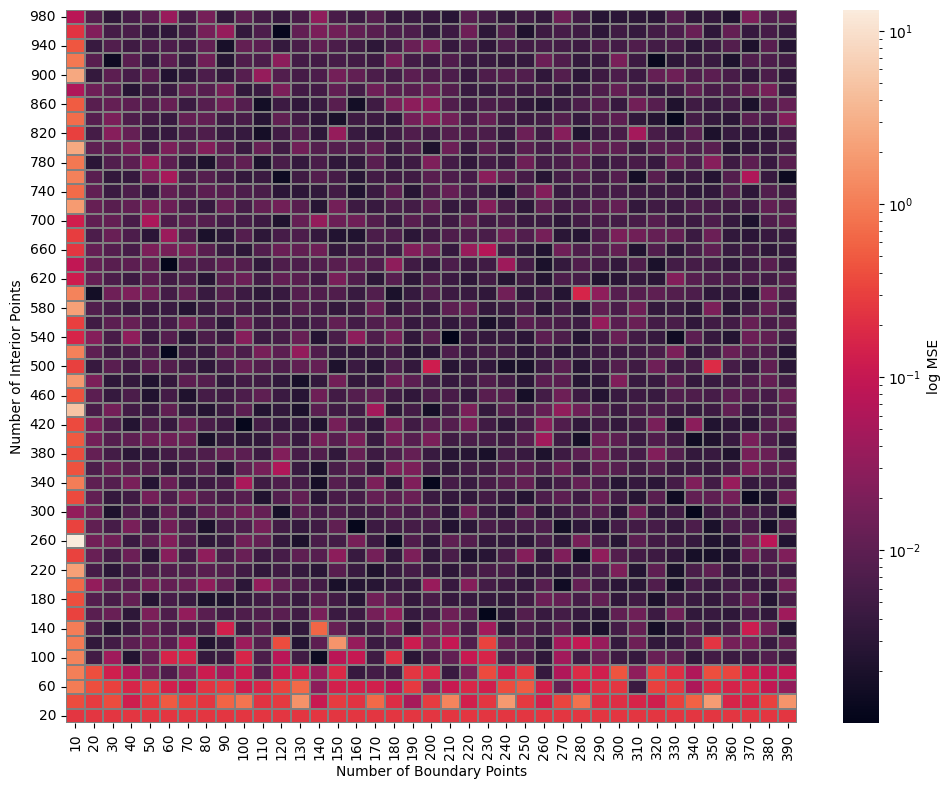

In [45]:
# Alright let's see how the error varies then using heatmaps again

results_df = pd.read_csv("Data/PDE_data/poisson_2D_results_uniform_spacing.csv")

# Pivot to get a 2D table: rows = n_interior, columns = n_boundary
heatmap_data = results_df.pivot(index="n_interior", columns="n_boundary", values="mse")

# Plot heatmap
plt.figure(figsize=(10, 8))
log_norm = mcolors.LogNorm(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())

sns.heatmap(
    heatmap_data,
    cmap="rocket",
    norm=log_norm,
    cbar_kws={"label": "log MSE"},
    linewidths=0.3,
    linecolor="gray"
)
plt.gca().invert_yaxis()
# plt.title("MSE vs Number of Interior and Boundary Points")
plt.xlabel("Number of Boundary Points")
plt.ylabel("Number of Interior Points")
plt.tight_layout()
plt.savefig("report/graphics/pde_uniform_sampling_heatmap.png", dpi=300)
plt.show()


Epoch 0: Loss = 3.150977e+03
Epoch 500: Loss = 3.995460e-01
Epoch 1000: Loss = 2.552337e-02


/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_85285/3916235096.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


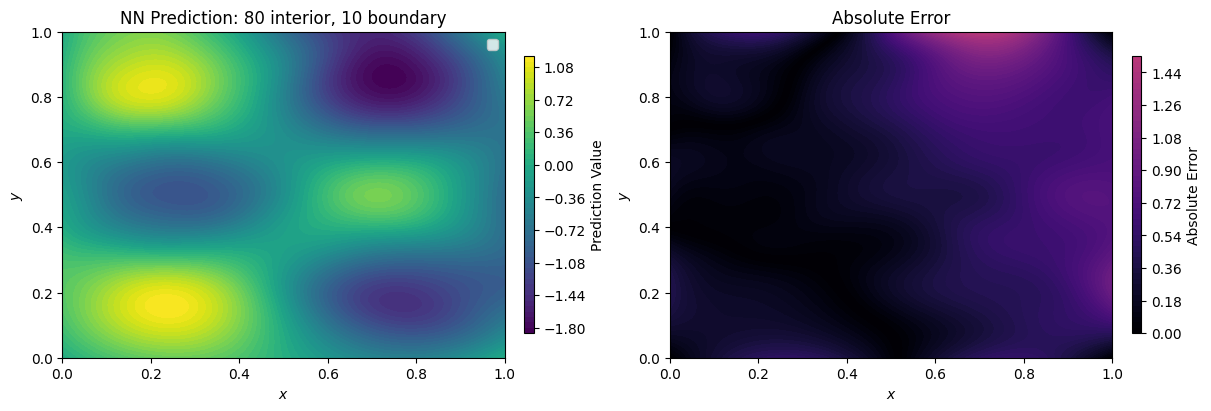

In [90]:
def plot_model_prediction_with_error(input_dim=2, output_dim=1, hidden_layers=3, hidden_units=10, 
                                    activation='tanh', x_int=400, x_bd=100):

    def true_solution(X, Y):
        return np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)

    def sample_points_regular(n_interior: int, n_boundary: int):
        import numpy as np
        import torch

        # === Interior: closest square grid of points ===
        nx = int(np.ceil(np.sqrt(n_interior)))
        ny = int(np.ceil(n_interior / nx))
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 1, ny)
        X, Y = np.meshgrid(x, y)
        interior_grid = np.stack([X.ravel(), Y.ravel()], axis=1)[:n_interior]
        x_interior = torch.tensor(interior_grid, dtype=torch.float32)

        # === Boundary: equidistant points around the square ===
        t = np.linspace(0, 4, n_boundary, endpoint=False)  # parametrize boundary
        x_boundary = []
        for val in t:
            if 0 <= val < 1:       # bottom edge (x from 0→1, y=0)
                x_boundary.append([val, 0.0])
            elif 1 <= val < 2:     # right edge (x=1, y from 0→1)
                x_boundary.append([1.0, val - 1])
            elif 2 <= val < 3:     # top edge (x from 1→0, y=1)
                x_boundary.append([3 - val, 1.0])
            else:                  # left edge (x=0, y from 1→0)
                x_boundary.append([0.0, 4 - val])
        x_boundary = torch.tensor(x_boundary, dtype=torch.float32)

        return x_interior, x_boundary




    model = FeedforwardNN(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layers,
                            hidden_units=hidden_units, activation=activation)
    train_poisson(model, epochs=1500, lr=1e-3, gamma=100.0, x_int=x_int, x_bd=x_bd)

    x = np.linspace(0, 1, 100, dtype=np.float32)
    y = np.linspace(0, 1, 100, dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)
    u_true = true_solution(X, Y)

    x_interior, x_boundary = sample_points(x_int, x_bd)
    model.eval()
    with torch.no_grad():
        u_pred = model(xy).view(100, 100).numpy()

    error = np.abs(u_pred - u_true)
    x_interior, x_boundary = sample_points(n_interior=x_int, n_boundary=x_bd)
    train_points = torch.cat([x_interior, x_boundary]).numpy()

    vmin, vmax = min(u_pred.min(), u_true.min()), max(u_pred.max(), u_true.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Prediction
    cf1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
    # axes[0].scatter(train_points[:, 0], train_points[:, 1], s=5, c='red', label='Training Points')
    axes[0].set_title("NN Prediction: 80 interior, 10 boundary")
    axes[0].set_xlabel("$x$")
    axes[0].set_ylabel("$y$")
    axes[0].legend()

    # # True
    # cf2 = axes[1].contourf(X, Y, u_true, levels=50, cmap='viridis', vmin=vmin, vmax=vmax)
    # axes[1].set_title("Exact Solution")
    # axes[1].set_xlabel("$x$")
    # axes[1].set_ylabel("$y$")

    # Error
    cf3 = axes[1].contourf(X, Y, error, levels=50, cmap='magma', vmin=0, vmax=3.0)
    axes[1].set_title("Absolute Error")
    axes[1].set_xlabel("$x$")
    axes[1].set_ylabel("$y$")

    fig.colorbar(cf1, ax=axes[0], orientation='vertical', shrink=0.85, aspect=30, pad=0.02, label="Prediction Value")
    fig.colorbar(cf3, ax=axes[1], orientation='vertical', shrink=0.85, aspect=30, pad=0.02, label="Absolute Error")

    # plt.suptitle("Model Prediction vs Ground Truth and Error", fontsize=14)
    plt.show()

plot_model_prediction_with_error(hidden_layers=3, hidden_units=30, activation='swish', 
                                x_int=80, x_bd=10)

Epoch 0: Loss = 3.152919e+03
Epoch 500: Loss = 4.792842e+02
Epoch 1000: Loss = 3.568204e+01


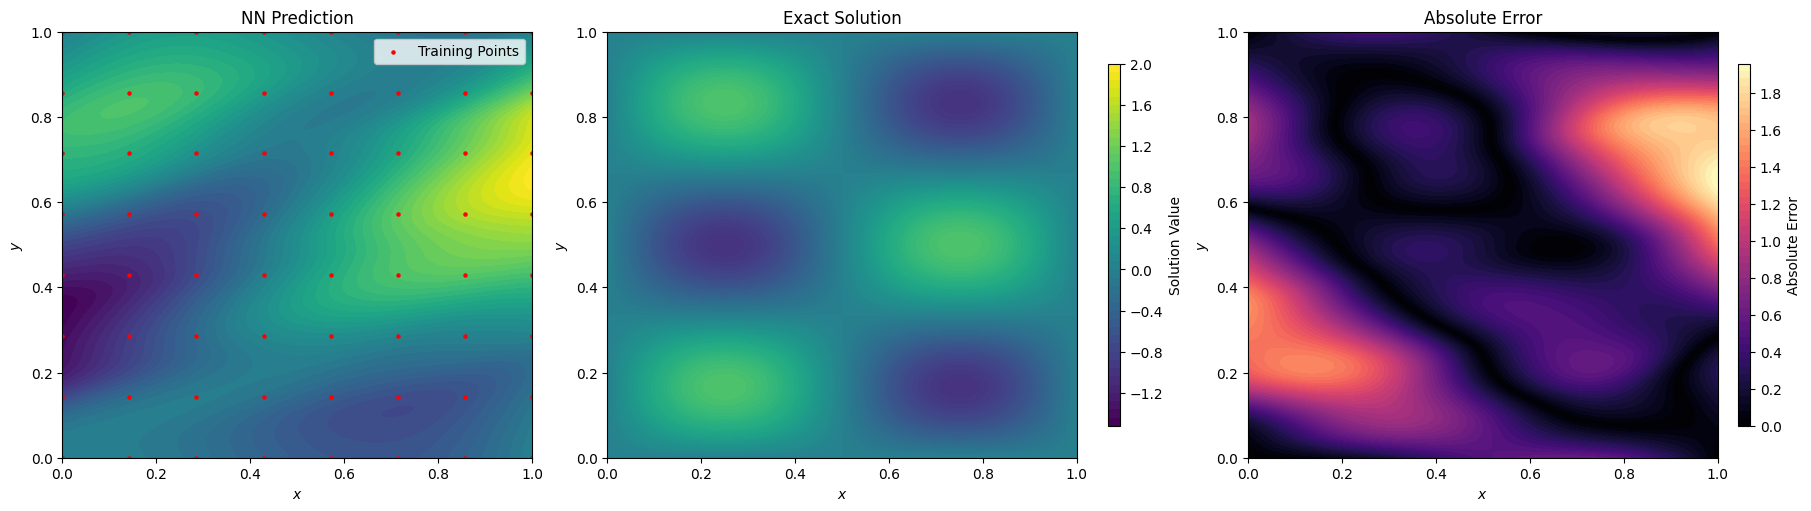

Epoch 0: Loss = 3.337624e+03
Epoch 500: Loss = 2.289387e+02
Epoch 1000: Loss = 1.750463e+00


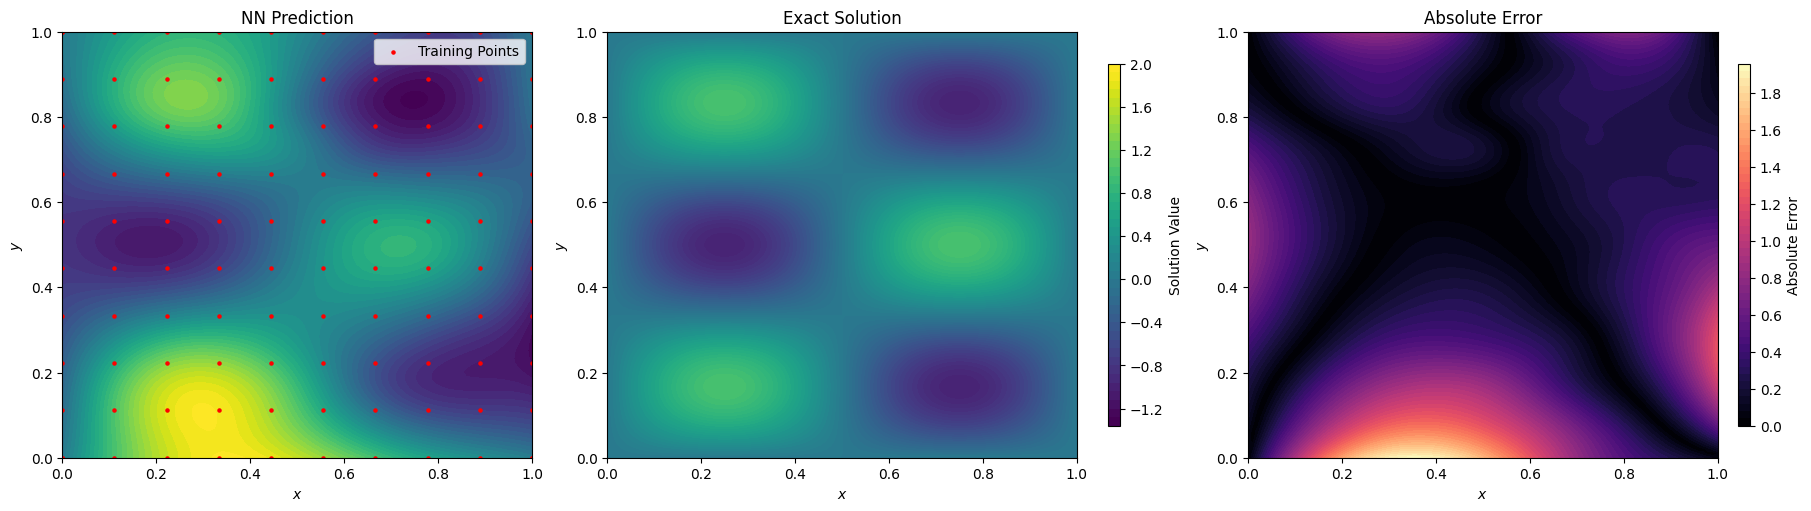

Epoch 0: Loss = 3.155813e+03
Epoch 500: Loss = 1.843461e+02
Epoch 1000: Loss = 3.027904e+00


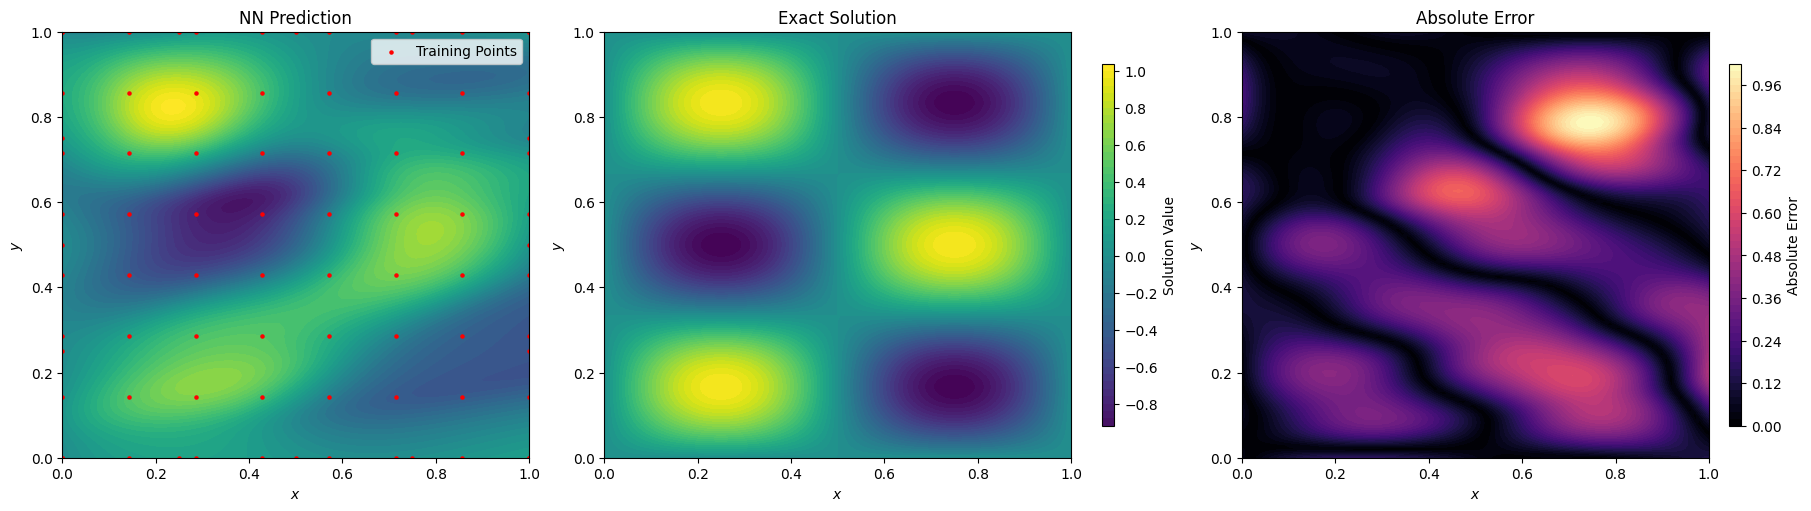

Epoch 0: Loss = 3.336987e+03
Epoch 500: Loss = 1.541406e+02
Epoch 1000: Loss = 9.543612e+00


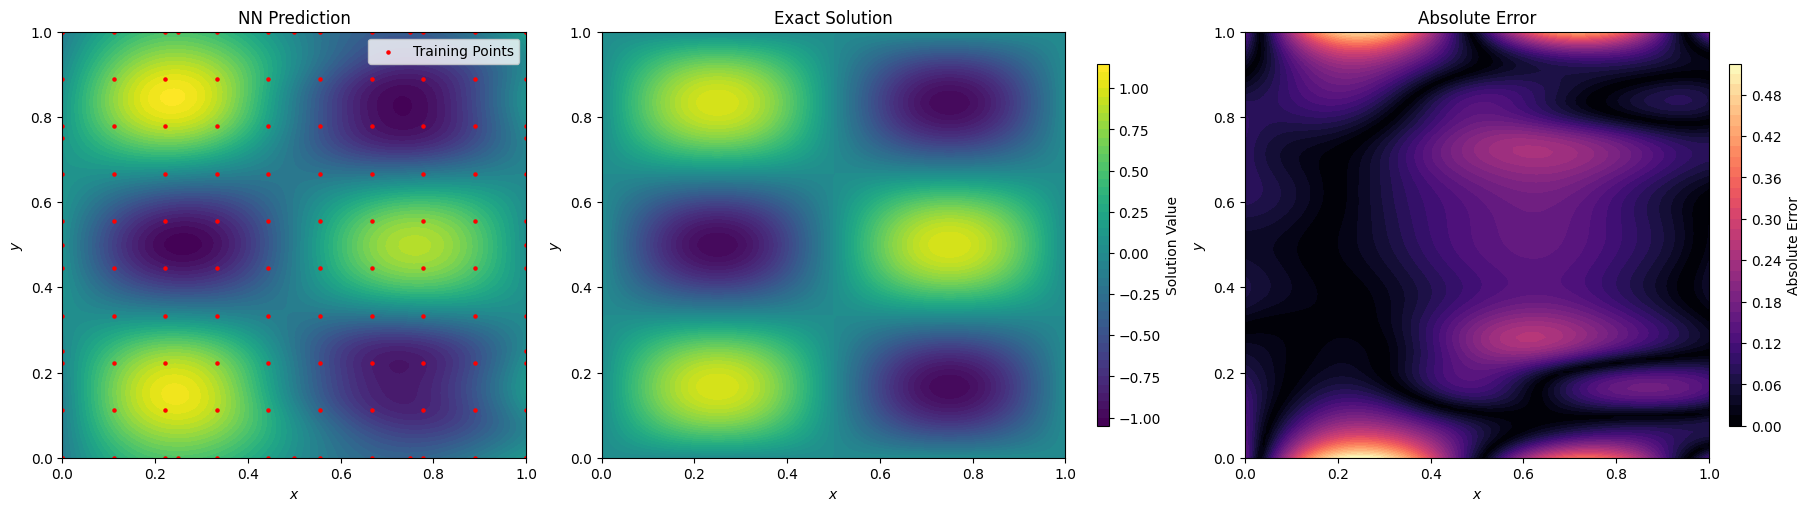

In [64]:
best_config = {
    "activation": "swish",
    "layers": int(best_configs["swish"]["layers"]),
    "width": int(best_configs["swish"]["width"])
}



plot_model_prediction_with_error(hidden_layers=best_config['layers'], 
                                hidden_units=best_config['width'], activation='swish', 
                                x_int=80, x_bd=10)
plot_model_prediction_with_error(hidden_layers=best_config['layers'], 
                                hidden_units=best_config['width'], activation='swish', 
                                x_int=100, x_bd=10)
plot_model_prediction_with_error(hidden_layers=best_config['layers'], 
                                hidden_units=best_config['width'], activation='swish', 
                                x_int=80, x_bd=20)
plot_model_prediction_with_error(hidden_layers=best_config['layers'], 
                                hidden_units=best_config['width'], activation='swish', 
                                x_int=100, x_bd=20)


Epoch 0: Loss = 3.158036e+03
Epoch 500: Loss = 2.054147e+02
Epoch 1000: Loss = 1.833485e+01
Epoch 0: Loss = 3.334036e+03
Epoch 500: Loss = 6.090569e+02
Epoch 1000: Loss = 5.845733e+01


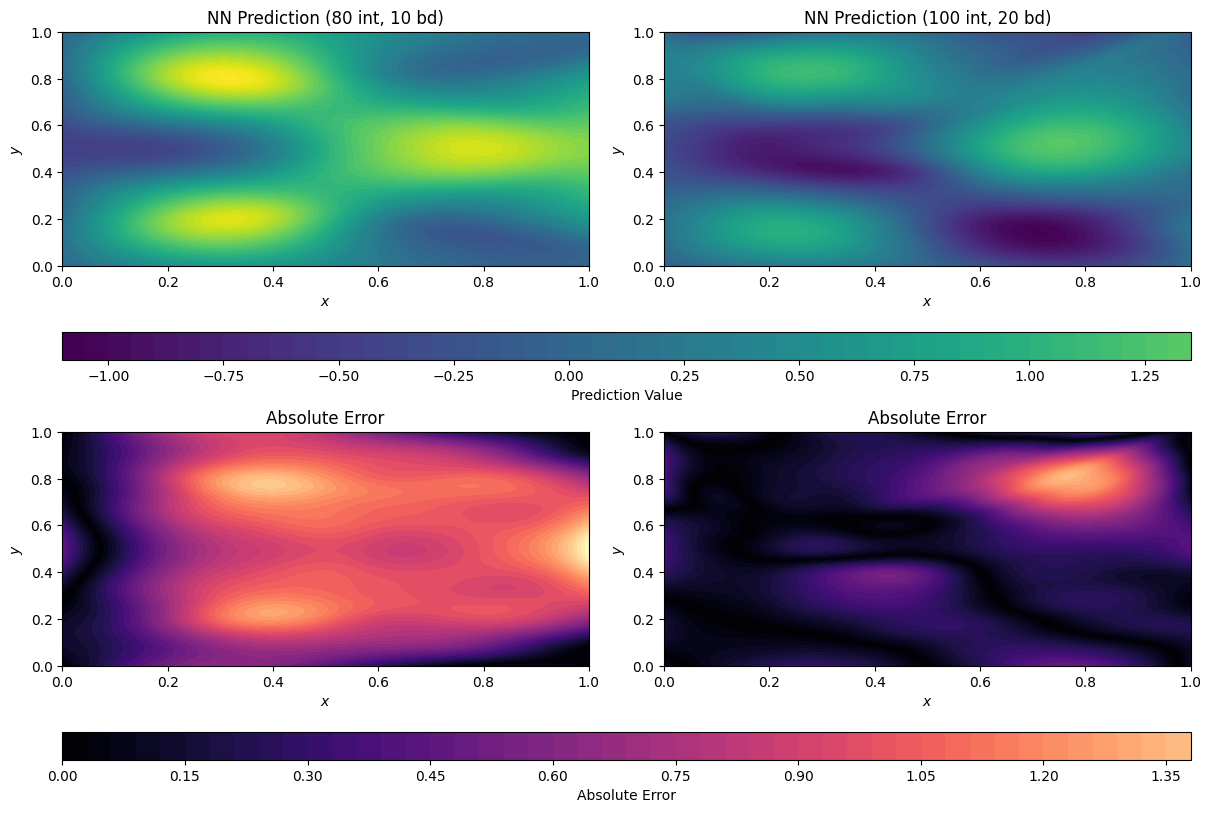

In [67]:
def compare_two_model_predictions(models, configs, xints, xbds, resolution=100):
    def true_solution(X, Y):
        return np.sin(2 * np.pi * X) * np.sin(3 * np.pi * Y)

    def sample_points_regular(n_interior: int, n_boundary: int):
        nx = int(np.ceil(np.sqrt(n_interior)))
        ny = int(np.ceil(n_interior / nx))
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 1, ny)
        X, Y = np.meshgrid(x, y)
        interior_grid = np.stack([X.ravel(), Y.ravel()], axis=1)[:n_interior]
        x_interior = torch.tensor(interior_grid, dtype=torch.float32)

        t = np.linspace(0, 4, n_boundary, endpoint=False)
        x_boundary = []
        for val in t:
            if 0 <= val < 1:
                x_boundary.append([val, 0.0])
            elif 1 <= val < 2:
                x_boundary.append([1.0, val - 1])
            elif 2 <= val < 3:
                x_boundary.append([3 - val, 1.0])
            else:
                x_boundary.append([0.0, 4 - val])
        x_boundary = torch.tensor(x_boundary, dtype=torch.float32)
        return x_interior, x_boundary

    # Evaluation grid
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)
    u_true = true_solution(X, Y)

    u_preds = []
    errors = []

    # Train and collect predictions/errors
    for model, xint, xbd in zip(models, xints, xbds):
        x_interior, x_boundary = sample_points_regular(xint, xbd)
        train_poisson(model, epochs=1500, lr=1e-3, gamma=100.0, x_int=xint, x_bd=xbd)

        with torch.no_grad():
            u_pred = model(xy).view(resolution, resolution).numpy()

        u_preds.append(u_pred)
        errors.append(np.abs(u_pred - u_true))

    # Color scales
    vmin = min(pred.min() for pred in u_preds)
    vmax = max(pred.max() for pred in u_preds)
    errmax = max(err.max() for err in errors)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

    for i in range(2):
        cf_pred = axes[0, i].contourf(X, Y, u_preds[i], levels=50, cmap="viridis", vmin=vmin, vmax=vmax)
        axes[0, i].set_title(f"NN Prediction ({configs[i]})")
        axes[0, i].set_xlabel("$x$")
        axes[0, i].set_ylabel("$y$")

        cf_err = axes[1, i].contourf(X, Y, errors[i], levels=50, cmap="magma", vmin=0, vmax=errmax)
        axes[1, i].set_title("Absolute Error")
        axes[1, i].set_xlabel("$x$")
        axes[1, i].set_ylabel("$y$")

    # Shared colorbars
    fig.colorbar(cf_pred, ax=axes[0, :], orientation='horizontal', pad=0.08, aspect=40, label="Prediction Value")
    fig.colorbar(cf_err, ax=axes[1, :], orientation='horizontal', pad=0.08, aspect=40, label="Absolute Error")
    plt.show()

best_config = {
    "activation": "swish",
    "layers": int(best_configs["swish"]["layers"]),
    "width": int(best_configs["swish"]["width"])
}

model1 = FeedforwardNN(2, 1, best_config["layers"], best_config["width"], activation="swish")
model2 = FeedforwardNN(2, 1, best_config["layers"], best_config["width"], activation="swish")

compare_two_model_predictions(
    models=[model1, model2],
    configs=["80 int, 10 bd", "100 int, 20 bd"],
    xints=[80, 100],
    xbds=[10, 20]
)
